![](https://kaskad-asu.com/images/customers/x5.jpg)
# BIGTARGET Hackathon from LENTA and Microsoft

**by team GORNYAKI (Samoshin Andriy and Tsepa Oleksii[Ukraine, KPI, IASA])**

Participants had to develop a solution that improves the effectiveness of SMS targeting in such a way that they only send messages to customers who are motivated to make a purchase. You must use the data provided by the retailer.

> Note: the organizers conducted a small features selection because the started data contained **more than 1000 columns**.

## Plan
1. [Quick View](#1)
1. [Missing Values](#2)
1. [Outliers](#3)
1. [Test vs Control](#4)
1. [About Uplift Modeling](#5)
1. [Our Model](#6)
1. [Insights](#7)

# Quick View

In [1]:
from sklearn.impute import SimpleImputer, KNNImputer
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

seed = 47

In [2]:
pdf_train = pd.read_csv('/kaggle/input/bigtarget/pdf (1).csv')
pdf = pdf_train.copy()
pdf.shape

(687029, 196)

In [3]:
pdf.head()

,CardHolder,age,cheque_count_12m_g20,cheque_count_12m_g21,cheque_count_12m_g25,cheque_count_12m_g32,cheque_count_12m_g33,cheque_count_12m_g38,cheque_count_12m_g39,cheque_count_12m_g41,...,sale_sum_6m_g24,sale_sum_6m_g25,sale_sum_6m_g26,sale_sum_6m_g32,sale_sum_6m_g33,sale_sum_6m_g44,sale_sum_6m_g54,stdev_days_between_visits_15d,stdev_discount_depth_15d,stdev_discount_depth_1m
0,16095858,47.0,3.0,22.0,19.0,3.0,28.0,8.0,7.0,6.0,...,3141.25,356.67,237.25,283.84,3648.23,1195.37,535.42,1.7078,0.2798,0.3008
1,15906620,57.0,1.0,0.0,2.0,1.0,1.0,1.0,0.0,1.0,...,113.39,62.69,58.71,87.01,179.83,0.00,122.98,0.0000,0.0000,0.0000
2,16495466,38.0,7.0,0.0,15.0,4.0,9.0,5.0,9.0,14.0,...,1239.19,533.46,83.37,593.13,1217.43,1336.83,3709.82,0.0000,NaN,0.0803
3,16570217,65.0,6.0,3.0,25.0,2.0,10.0,14.0,11.0,8.0,...,139.68,1849.91,360.40,175.73,496.73,172.58,1246.21,0.0000,0.0000,0.0000
4,16346871,61.0,0.0,1.0,2.0,0.0,2.0,1.0,0.0,3.0,...,226.98,168.05,461.37,0.00,237.93,225.51,995.27,1.4142,0.3495,0.3495


* There are 196 columns in the dataset
* The target variable is **response_att** - we have to predict whether the client will respond to the market mailing
* Audience is divided into 2 samples - **test** and **control**
* The dataset gives us basic information about the client, for example, his **age**, **number of children**
* There is also a lot of information about some groups of goods (it's necessary for searching insights) and a lot of statistical information for example the **coefficients of variation** of discounts or prices

There are also few categorical columns: **gender** and **group**. We transform them into binary features.

In [4]:
gender_map = {'Ж': 0, 'М': 1}
group_map = {'test': 0, 'control': 1}
pdf['gender'] = pdf['gender'].map(gender_map)
pdf['group'] = pdf['group'].map(group_map)

# Missing Values

In [5]:
print('Number NA:', pdf.isna().sum().sum())
print('Amount of all values:', pdf.shape[0]*pdf.shape[1])
print('Missed Data Percentage:', round(100*pdf.isna().sum().sum()/(pdf.shape[0]*pdf.shape[1]), 2), '%')

Number NA: 25640556
Amount of all values: 134657684
Missed Data Percentage: 19.04 %


In [6]:
#missing data
total = pdf.isnull().sum().sort_values(ascending=False)
percent = (pdf.isnull().sum()/pdf.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
k_var_sku_price_15d_g49,496259,0.722326
k_var_disc_share_15d_g49,496159,0.722181
k_var_count_per_cheque_15d_g34,468551,0.681996
k_var_sku_price_15d_g34,468551,0.681996
k_var_disc_share_15d_g34,468467,0.681874
k_var_count_per_cheque_15d_g24,442121,0.643526
k_var_disc_share_15d_g24,442054,0.643428
k_var_sku_price_1m_g49,414473,0.603283
k_var_count_per_cheque_1m_g49,414473,0.603283
k_var_disc_share_1m_g49,414369,0.603132


In [7]:
#dealing with missing data
pdf = pdf.fillna(np.nan)
pdf_col_list = list(pdf.columns)
imputer = SimpleImputer(missing_values=np.nan, strategy='median')
pdf = pd.DataFrame(imputer.fit_transform(pdf), columns=pdf_col_list)

print('Number NA:', pdf.isna().sum().sum())

Number NA: 0


# Outliers

We should be aware of outliers. Why? Because outliers can markedly affect on our models and can be a valuable source of information providing us insights about specific behaviours.

Outliers is a complex subject and it deserves more attention. Here, we'll just do a quick analysis

In [8]:
# Group number is in range from 20 to 79
all_groups = [i for i in range(20, 80)]
pdf_outliers = pdf.copy()

# This function returns columns from 'columns' list, which are met in columns of "data"
def get_columns_list(data, columns):
    return data.columns[data.columns.isin(columns)]

We will collect the features that interest us: some are already in the dataset, some will have to be collected separately. These features describe the data in general way but for a fact-finding analysis this is enough.

In [9]:
collect_features = {
    'cheque_count_12m_max'             : (get_columns_list(pdf_outliers, ['cheque_count_12m_g{}'.format(i) for i in all_groups]), 'sum'),
    'children'                         : (['children'], 'max'),
    'crazy_purchases_cheque_count_12m' : (['crazy_purchases_cheque_count_12m'], 'max'),
    'k_var_disc_share_6m_max'          : (get_columns_list(pdf_outliers, ['k_var_disc_share_6m_g{}'.format(i) for i in all_groups]), 'max'),
    'k_var_sku_price_6m_max'           : (get_columns_list(pdf_outliers, ['k_var_sku_price_6m_g{}'.format(i) for i in all_groups]), 'max'),
    'sale_sum_12m_sum'                  : (get_columns_list(pdf_outliers, ['sale_sum_6m_g{}'.format(i) for i in all_groups]), 'sum'),
}

In [10]:
for key in collect_features.keys():
    method = collect_features[key][1]
    
    if method == 'max':
        pdf_outliers.loc[:, key] = pdf_outliers[collect_features[key][0]].max(axis=1)
    elif method == 'sum':
        pdf_outliers.loc[:, key] = pdf_outliers[collect_features[key][0]].sum(axis=1)
    elif method == 'max':
        pdf_outliers.loc[:, key] = pdf_outliers[collect_features[key][0]].max(axis=1)
    elif method == 'min':
        pdf_outliers.loc[:, key] = pdf_outliers[collect_features[key][0]].min(axis=1)

According to the collected features, we look at the outliers, which are determined **by the proportions relative to the IQR**. We will divide the obtained records into records from the test and control groups and divide them by participation in our chosen action. Let's look at the results.

Column cheque_count_12m_max
        Type  whis 1.5  whis 2  whis 2.5  whis 3
0     test_0    432047  440669    446363  450331
1     test_1     41853   45024     47506   49516
2  control_0    144816  147624    149541  150787
3  control_1     12905   13940     14704   15318


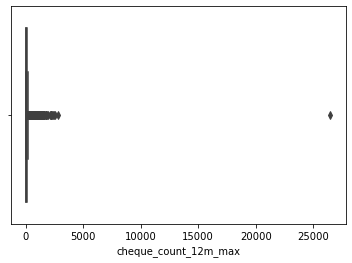

Column children
        Type  whis 1.5  whis 2  whis 2.5  whis 3
0     test_0    442262  458644    458644  458990
1     test_1     54883   56750     56750   56794
2  control_0    147990  153417    153417  153544
3  control_1     16957   17538     17538   17551


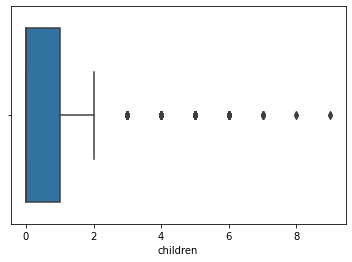

Column crazy_purchases_cheque_count_12m
        Type  whis 1.5  whis 2  whis 2.5  whis 3
0     test_0    428149  438737    442364  447457
1     test_1     43475   46811     48116   50164
2  control_0    143750  147196    148333  149976
3  control_1     13620   14654     15050   15635


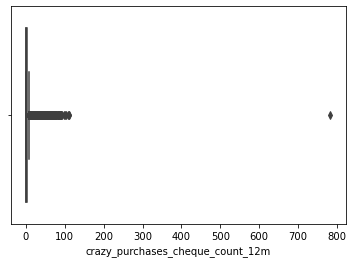

Column k_var_disc_share_6m_max
        Type  whis 1.5  whis 2  whis 2.5  whis 3
0     test_0    452124  456528    457820  458253
1     test_1     54341   55737     56159   56327
2  control_0    151262  152677    153145  153295
3  control_1     16801   17217     17368   17421


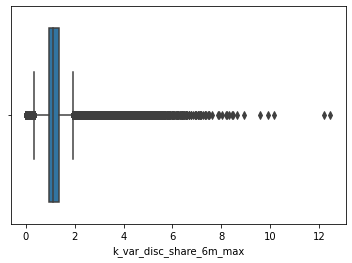

Column k_var_sku_price_6m_max
        Type  whis 1.5  whis 2  whis 2.5  whis 3
0     test_0    443596  451330    455167  457150
1     test_1     51079   53613     54995   55826
2  control_0    148311  150978    152281  152916
3  control_1     15695   16538     17013   17250


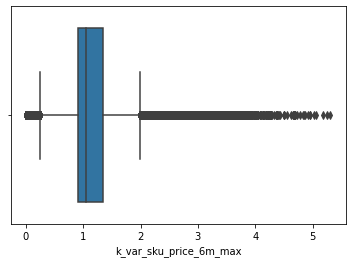

Column sale_sum_12m_sum
        Type  whis 1.5  whis 2  whis 2.5  whis 3
0     test_0    426043  434514    440589  444906
1     test_1     41159   44100     46483   48295
2  control_0    142866  145743    147688  149051
3  control_1     12717   13609     14299   14881


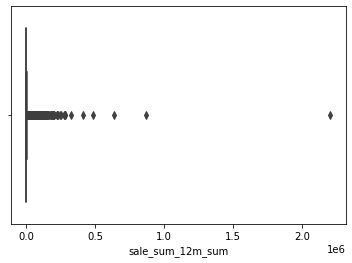

In [11]:
for key in collect_features.keys():
    print('Column', key)
    
    dataframe = {'Type' : ['test_0', 'test_1', 'control_0', 'control_1']}
    for whis in [1.5, 2, 2.5, 3]:
        IQR = pdf_outliers[key].quantile(0.75) - pdf_outliers[key].quantile(0.25)
        sample = pdf_outliers[pdf_outliers[key] <= pdf_outliers[key].quantile(0.75) + IQR * whis]
        sample_test = sample[sample['group'] == 0]['response_att'].value_counts()
        sample_control = sample[sample['group'] == 1]['response_att'].value_counts()
        
        dataframe['whis {}'.format(whis)] = [sample_test[0], sample_test[1], sample_control[0], sample_control[1]]
    
    print(pd.DataFrame(dataframe))
    sns.boxplot(pdf_outliers[key])
    plt.show()

Column cheque_count_12m_max
        Type  whis 1.5  whis 2  whis 2.5  whis 3
0     test_0     27032   18410     12716    8748
1     test_1     14960   11789      9307    7297
2  control_0      8766    5958      4041    2795
3  control_1      4650    3615      2851    2237


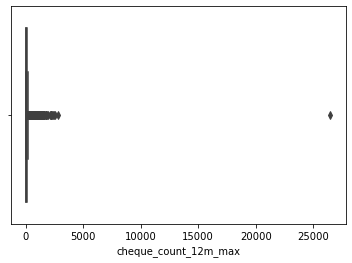

Column children
        Type  whis 1.5  whis 2  whis 2.5  whis 3
0     test_0     16817     435       435      89
1     test_1      1930      63        63      19
2  control_0      5592     165       165      38
3  control_1       598      17        17       4


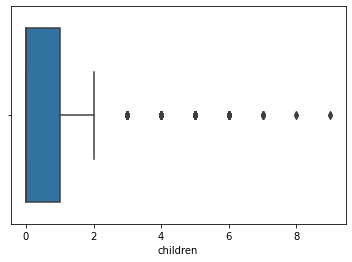

Column crazy_purchases_cheque_count_12m
        Type  whis 1.5  whis 2  whis 2.5  whis 3
0     test_0     30930   20342     16715   11622
1     test_1     13338   10002      8697    6649
2  control_0      9832    6386      5249    3606
3  control_1      3935    2901      2505    1920


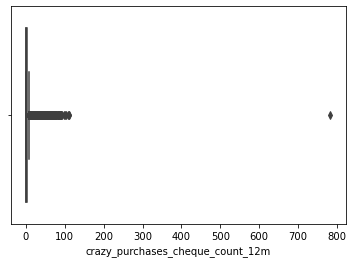

Column k_var_disc_share_6m_max
        Type  whis 1.5  whis 2  whis 2.5  whis 3
0     test_0      6955    2551      1259     826
1     test_1      2472    1076       654     486
2  control_0      2320     905       437     287
3  control_1       754     338       187     134


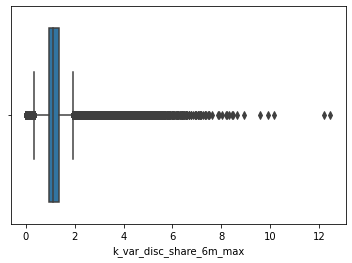

Column k_var_sku_price_6m_max
        Type  whis 1.5  whis 2  whis 2.5  whis 3
0     test_0     15483    7749      3912    1929
1     test_1      5734    3200      1818     987
2  control_0      5271    2604      1301     666
3  control_1      1860    1017       542     305


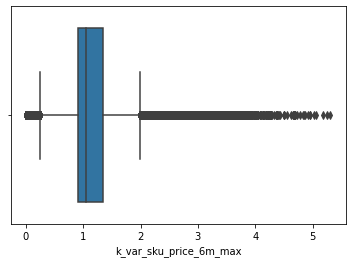

Column sale_sum_12m_sum
        Type  whis 1.5  whis 2  whis 2.5  whis 3
0     test_0     33036   24565     18490   14173
1     test_1     15654   12713     10330    8518
2  control_0     10716    7839      5894    4531
3  control_1      4838    3946      3256    2674


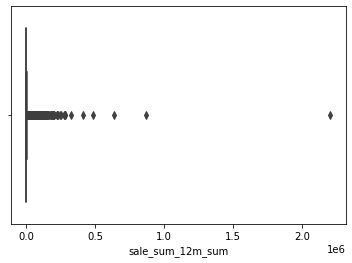

In [12]:
for key in collect_features.keys():
    print('Column', key)
    
    dataframe = {'Type' : ['test_0', 'test_1', 'control_0', 'control_1']}
    for whis in [1.5, 2, 2.5, 3]:
        IQR = pdf_outliers[key].quantile(0.75) - pdf_outliers[key].quantile(0.25)
        sample = pdf_outliers[pdf_outliers[key] > pdf_outliers[key].quantile(0.75) + IQR * whis]
        sample_test = sample[sample['group'] == 0]['response_att'].value_counts()
        sample_control = sample[sample['group'] == 1]['response_att'].value_counts()
        
        dataframe['whis {}'.format(whis)] = [sample_test[0], sample_test[1], sample_control[0], sample_control[1]]
    
    print(pd.DataFrame(dataframe))
    sns.boxplot(pdf_outliers[key])
    plt.show()

> There are a lot of outliers but most of the selected features were artificially collected. We may have mistook seasonal anomalies for outliers.

Also take a look at the correlation between features.

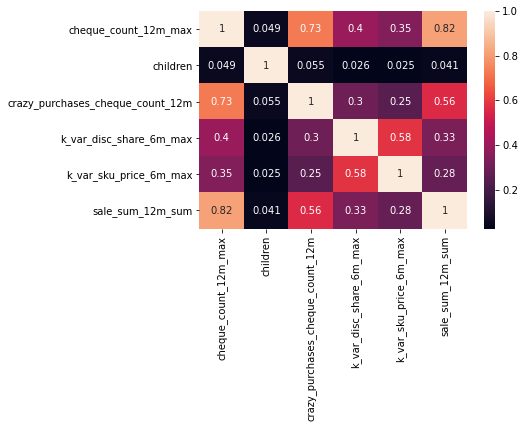

In [13]:
sns.heatmap(pdf_outliers[[key for key in collect_features.keys()]].corr(), annot=True)

In [14]:
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, a, b):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[a:b]

print("Top Absolute Correlations")
print(get_top_abs_correlations(pdf, 0, 10))

Top Absolute Correlations
mean_discount_depth_15d          promo_share_15d                 0.981232
k_var_cheque_category_width_15d  k_var_cheque_group_width_15d    0.974657
                                 k_var_sku_per_cheque_15d        0.971853
sale_count_3m_g33                sale_sum_3m_g33                 0.947343
sale_count_6m_g33                sale_sum_6m_g33                 0.946432
k_var_cheque_group_width_15d     k_var_sku_per_cheque_15d        0.946405
sale_count_12m_g54               sale_sum_12m_g54                0.945453
k_var_discount_depth_15d         stdev_discount_depth_15d        0.944149
sale_count_6m_g54                sale_sum_6m_g54                 0.942185
sale_sum_12m_g24                 sale_sum_6m_g24                 0.941417
dtype: float64


# Test vs Control

Just note that the control and test groups are **not balanced**. The ratio of the control to the test **1 to 3**. The total number of observations: **687000**.

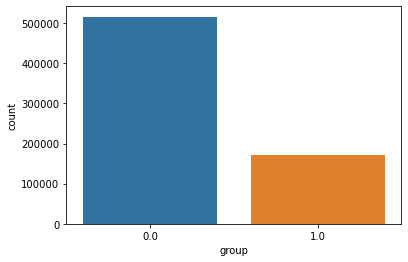

In [15]:
sns.countplot(x="group", data=pdf)

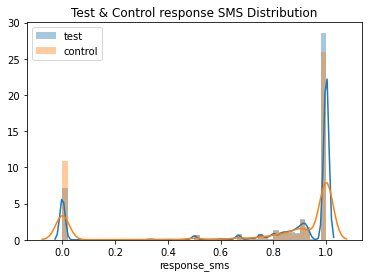

In [16]:
test = pdf[pdf['group'] == 0]

control = pdf[pdf['group'] == 1]

sns.distplot(test['response_sms'], label='test')
sns.distplot(control['response_sms'], label='control')
plt.title('Test & Control response SMS Distribution')
plt.legend()
plt.show()

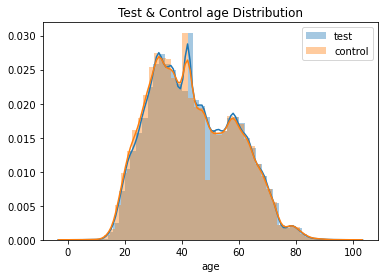

In [17]:
test = pdf[pdf['group'] == 0]

control = pdf[pdf['group'] == 1]

sns.distplot(test['age'], label='test')
sns.distplot(control['age'], label='control')
plt.title('Test & Control age Distribution')
plt.legend()
plt.show()

## Comparison on some features

We will divide customers into 2 classes depending on whether they participated in the promotion.

In [18]:
# Test participants who didn't take part in event
stubborn_test = pdf[pdf['group'] == 0]
stubborn_test = stubborn_test[stubborn_test['response_att'] == 0]

# Test participants who took part in event
active_test = pdf[pdf['group'] == 0]
active_test = active_test[active_test['response_att'] == 1]

In [19]:
# Control participants who didn't take part in event
stubborn_control = pdf[pdf['group'] == 1]
stubborn_control = stubborn_control[stubborn_control['response_att'] == 0]

# Control participants who took part in event
active_control = pdf[pdf['group'] == 1]
active_control = active_control[active_control['response_att'] == 1]

Text(0, 0.5, 'Control group')

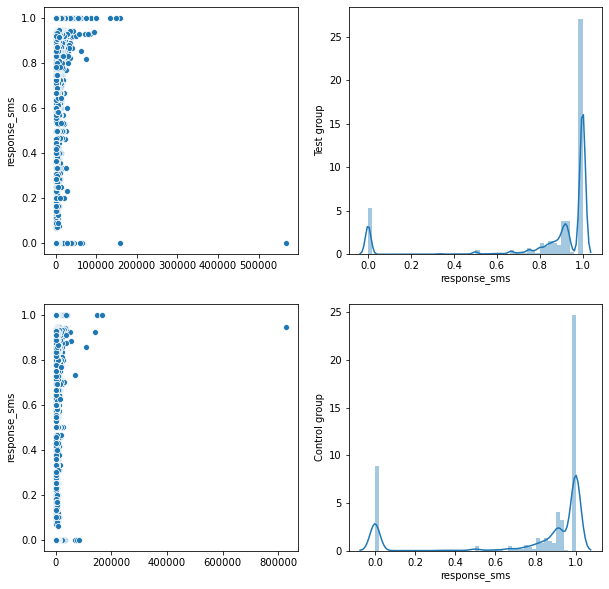

In [20]:
sales_sum = ['sale_sum_3m_g{}'.format(i) for i in [24, 26, 32, 33]]

f, axs = plt.subplots(2, 2, figsize=(10, 10))

sns.scatterplot(active_test[sales_sum].sum(axis=1), active_test['response_sms'], ax=axs[0, 0])
sns.distplot(active_test['response_sms'], ax=axs[0, 1])
axs[0, 1].set_ylabel('Test group')

sns.scatterplot(active_control[sales_sum].sum(axis=1), active_control['response_sms'], ax=axs[1, 0])
sns.distplot(active_control['response_sms'], ax=axs[1, 1])
axs[1, 1].set_ylabel('Control group')

Text(0, 0.5, 'Control group')

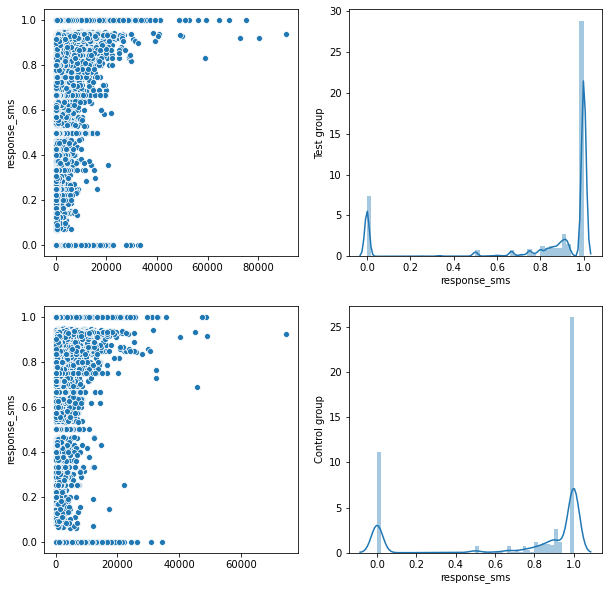

In [21]:
sales_sum = ['sale_sum_3m_g{}'.format(i) for i in [24, 26, 32, 33]]

f, axs = plt.subplots(2, 2, figsize=(10, 10))

sns.scatterplot(stubborn_test[sales_sum].sum(axis=1), stubborn_test['response_sms'], ax=axs[0, 0])
sns.distplot(stubborn_test['response_sms'], ax=axs[0, 1])
axs[0, 1].set_ylabel('Test group')

sns.scatterplot(stubborn_control[sales_sum].sum(axis=1), stubborn_control['response_sms'], ax=axs[1, 0])
sns.distplot(stubborn_control['response_sms'], ax=axs[1, 1])
axs[1, 1].set_ylabel('Control group')

We observe a **lower right peak** which corresponds to the probability of response to SMS 100% for the control sample.

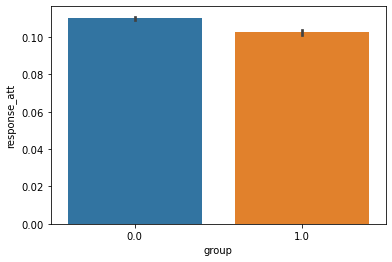

In [22]:
sns.barplot(x = 'group', y='response_att', data=pdf)

In the interaction  proportion of customers who completed the target action is **11.01%**. Without interaction, **10.25%**. So the effect of the mailing **increases this share by 0.75%**.

# About Uplift Modeling

Uplift modeling estimates the effect of communication action on some customer outcome and gives an opportunity to efficiently target customers which are most likely to respond to a marketing campaign. It is relatively easy to implement, but surprisingly poorly covered in the machine learning courses and literature.

Companies use various channels to promote a product to a customer: it can be SMS, push notification, chatbot message in social networks, and many others. There are several ways to use machine learning to select customers for a marketing campaign:

![](https://scikit-uplift.readthedocs.io/en/latest/_images/ug_comparison_with_other_models.png)

* **The Look-alike model** (or Positive Unlabeled Learning) evaluates a probability that the customer is going to accomplish a target action. A training dataset contains known positive objects (for instance, users who have installed an app) and random negative objects (a random subset of all other customers who have not installed the app). The model searches for customers who are similar to those who made the target action.

* **The Response model** evaluates the probability that the customer is going to accomplish the target action if there was a communication (a.k.a treatment). In this case the training dataset is data collected after some interaction with the customers. In contrast to the first approach, we have confirmed positive and negative observations at our disposal (for instance, the customer who decides to issue a credit card or to decline an offer).

* **The Uplift model** evaluates the net effect of communication by trying to select only those customers who are going to perform the target action only when there is some advertising exposure presenting to them. The model predicts a difference between the customer’s behavior when there is a treatment (communication) and when there is no treatment (no communication).

> You can find more theory in the [documentation](https://scikit-uplift.readthedocs.io/en/latest/user_guide/introduction/cate.html).


## Types of customers

We can determine 4 types of customers based on a response to a treatment:

![](https://scikit-uplift.readthedocs.io/en/latest/_images/ug_clients_types.jpg)

* **Do-Not-Disturbs** (a.k.a. Sleeping-dogs) have a strong negative response to a marketing communication. They are going to purchase if NOT treated and will NOT purchase IF treated. It is not only a wasted marketing budget but also a negative impact.

* **Lost Causes** will NOT purchase the product NO MATTER they are contacted or not. The marketing budget in this case is also wasted because it has no effect.

* **Sure Things** will purchase ANYWAY no matter they are contacted or not. There is no motivation to spend the budget because it also has no effect.

* **Persuadables** will always respond POSITIVE to the marketing communication. They is going to purchase ONLY if contacted (or sometimes they purchase MORE or EARLIER only if contacted).

# Our Model

The main idea was to use [**Class Transformation**](https://scikit-uplift.readthedocs.io/en/latest/user_guide/models/revert_label.html). Simple but powerful and mathematically proven uplift modeling method, presented in 2012. The main idea is to predict a slightly changed target:

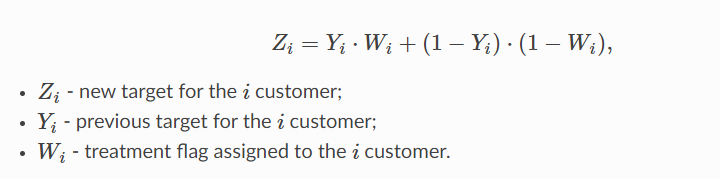

In other words the new target equals 1 if a response in the treatment group is as good as a response in the control group and equals 0 otherwise.

In [23]:
!pip install scikit-uplift -q

from sklearn.model_selection import train_test_split
from sklift.models import ClassTransformation
from sklift.viz.base import plot_uplift_by_percentile
from sklift.metrics import uplift_at_k, uplift_auc_score, qini_auc_score
from sklearn.base import clone

from catboost import CatBoostClassifier

seed=47

### Simple preprocessing

In [24]:
gen_dict = {
    'Ж':0,
    'М':1,
    'Не определен': -1
}

treat_dict = {
    'test': 1,
    'control': 0
}

pdf_train.loc[:, 'gender'] = pdf_train['gender'].map(gen_dict)
pdf_train.loc[:, 'group'] = pdf_train['group'].map(treat_dict)

drop_cols = ['CardHolder', 'group', 'response_att']
try_feat = list(set(pdf_train.columns.tolist()) - set(drop_cols))

### Create model

In [25]:
estimator = CatBoostClassifier(verbose=100, random_state=seed)

uplift_model_cl_tr = ClassTransformation(
    estimator=estimator
)

In [26]:
df_tr, df_val = train_test_split(
    pdf_train, 
    test_size=0.3, 
    stratify=pdf['response_att'], 
    random_state=seed
)

In [27]:
model = clone(uplift_model_cl_tr)

model.fit(
    X=df_tr[try_feat], 
    y=df_tr['response_att'], 
    treatment=df_tr['group'])

pred_tr = model.predict(df_tr[try_feat])
pred_val = model.predict(df_val[try_feat])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: It is recommended to use this approach on treatment balanced data. Current sample size is unbalanced.
  


Learning rate set to 0.143939
0:	learn: 0.6702481	total: 437ms	remaining: 7m 16s
100:	learn: 0.5949230	total: 32.9s	remaining: 4m 52s
200:	learn: 0.5904701	total: 1m 3s	remaining: 4m 13s
300:	learn: 0.5867080	total: 1m 35s	remaining: 3m 42s
400:	learn: 0.5831643	total: 2m 7s	remaining: 3m 10s
500:	learn: 0.5797509	total: 2m 39s	remaining: 2m 39s
600:	learn: 0.5764093	total: 3m 11s	remaining: 2m 7s
700:	learn: 0.5732090	total: 3m 44s	remaining: 1m 35s
800:	learn: 0.5701595	total: 4m 15s	remaining: 1m 3s
900:	learn: 0.5673066	total: 4m 48s	remaining: 31.7s
999:	learn: 0.5644249	total: 5m 19s	remaining: 0us


### Create metric

In [28]:
def custom_metric(
    y_true, 
    uplift, 
    treatment,
    take_top_ratio=0.25
):
    answers = pd.DataFrame(data={
        'response_att':y_true,
        'uplift': uplift,
        'group': treatment
    })
    
    answers.sort_values(by='uplift', inplace=True, ascending=False)
    n_samples = int(np.ceil(answers.shape[0] * take_top_ratio))
    answers = answers.iloc[:n_samples, :]
    answers_test = answers[answers['group'] == 1]['response_att'].sum() / \
                   answers[answers['group'] == 1].shape[0]
    answers_control = answers[answers['group'] == 0]['response_att'].sum() / \
                      answers[answers['group'] == 0].shape[0]
    return (answers_test - answers_control)


def custom_metric_orig(answers, take_top_ratio=0.25):
    answers.sort_values(by='uplift', inplace=True, ascending=False)
    n_samples = int(np.ceil(answers.shape[0] * take_top_ratio))
    answers = answers.iloc[:n_samples, :]
    answers_test = answers[answers['group'] == 'test']['response_att'].sum() / \
                   answers[answers['group'] == 'test'].shape[0]
    answers_control = answers[answers['group'] == 'control']['response_att'].sum() / \
                      answers[answers['group'] == 'control'].shape[0]
    return (answers_test - answers_control)*100

In [29]:
def print_metrics(df_tr, df_val, pred_tr, pred_val):
    
    uplift_tr_cust = custom_metric(
        y_true=df_tr['response_att'], 
        uplift=pred_tr, 
        treatment=df_tr['group']
)

    uplift_val_cust = custom_metric(
        y_true=df_val['response_att'], 
        uplift=pred_val, 
        treatment=df_val['group']
    )

    uplift_tr = uplift_at_k(
        y_true=df_tr['response_att'], 
        uplift=pred_tr, 
        treatment=df_tr['group'],
        strategy='overall',
        k=0.25
    )
    
    uplift_val = uplift_at_k(
        y_true=df_val['response_att'], 
        uplift=pred_val, 
        treatment=df_val['group'],
        strategy='overall',
        k=0.25
    )

    print(f'Uplift train, custom: {uplift_tr_cust:.5f}')
    print(f'Uplift val,   custom: {uplift_val_cust:.5f}\n')

    print(f'Uplift train: {uplift_tr:.5f}')
    print(f'Uplift val:   {uplift_val:.5f}')

In [30]:
print_metrics(
    df_tr, df_val, 
    pred_tr, pred_val)

Uplift train, custom: 0.20903
Uplift val,   custom: 0.06070

Uplift train: 0.20903
Uplift val:   0.06071


### Inference

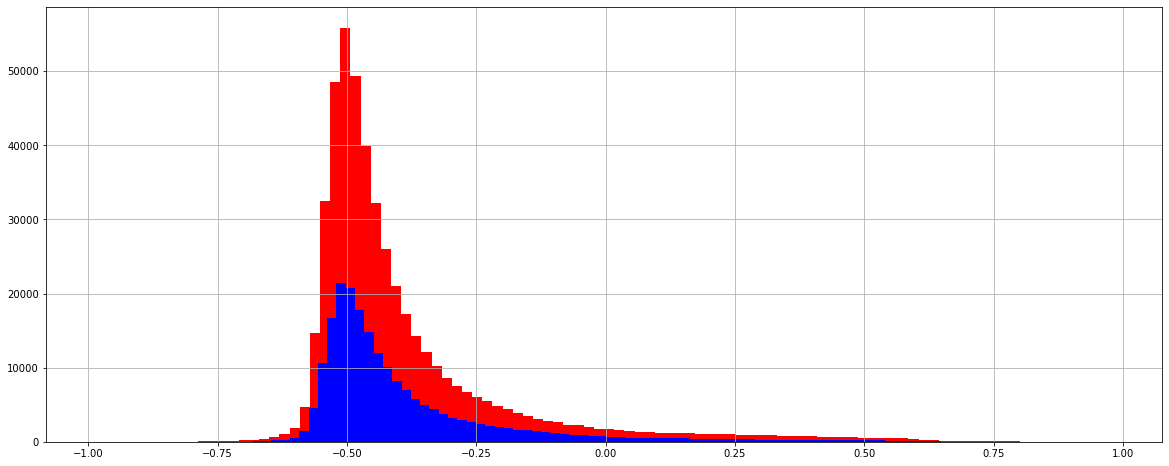

In [31]:
plt.figure(figsize=(20, 8))
pd.Series(pred_tr).hist(bins=100, color='red')
pd.Series(pred_val).hist(bins=100, color='blue')

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f7360871550>,
      dtype=object)

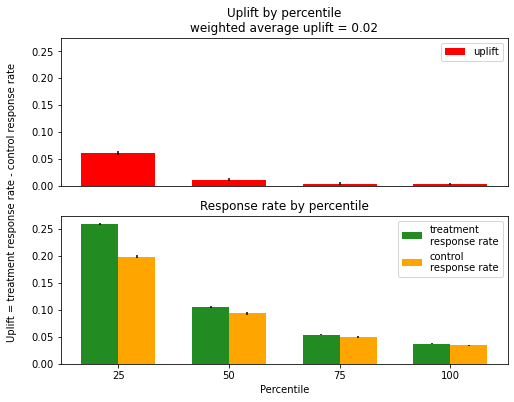

In [32]:
plot_uplift_by_percentile(
    y_true=df_val['response_att'], 
    uplift=pred_val, 
    treatment=df_val['group'],
    bins=4,
    kind='bar'
)

In [33]:
model.estimator.get_feature_importance(prettified=True).head(10)

,Feature Id,Importances
0,response_sms,7.901875
1,response_viber,6.380208
2,months_from_register,2.172596
3,k_var_days_between_visits_15d,1.451285
4,k_var_days_between_visits_3m,1.171004
5,k_var_cheque_3m,0.979516
6,perdelta_days_between_visits_15_30d,0.976329
7,promo_share_15d,0.955921
8,food_share_1m,0.925056
9,food_share_15d,0.899296


# Insights

This item is necessary for a clear interpretation of our model in order to show the organizers how to increase the company's metrics. We will describe the main ones that we found and their solutions.
> For a more convenient search we will group by age categories.

In [34]:
pdf['age_group'] = pdf['age'].apply(lambda x: '0-12' if x<12
                                   else '13-18' if x<18 and x>12
                                   else '19-35' if x<35 and x>18
                                   else '36-60' if x<60 and x>35
                                   else '60+')

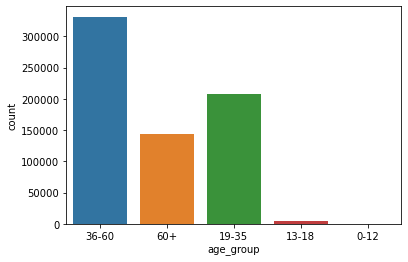

In [35]:
sns.countplot(x="age_group", data=pdf)

## Dependence of the share of purchase food on the number of children

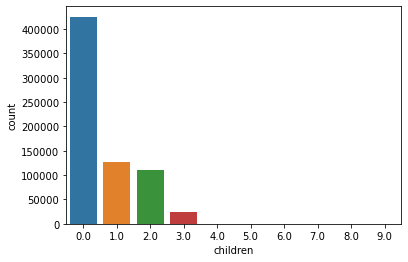

In [36]:
sns.countplot(x="children", data=pdf)
plt.show()

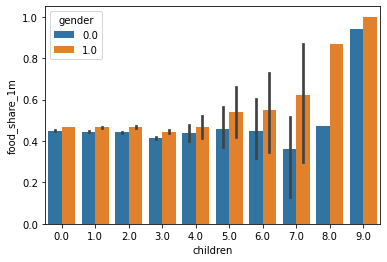

In [37]:
sns.barplot(x="children", y="food_share_1m", hue="gender", data=pdf)

Our hypothesis is that the more children in the family, the more often the father is sent to the store. Perhaps this is due to the large number of heavy packages. And this graph illustrates: **the more children, the more pronounced increase in the proportion of men.**

**How to increase customer loyalty and profit?** Create a special discount system for parents, which will depend on the number of children.

## Crazy Purchases

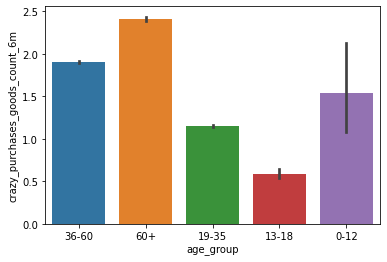

In [38]:
sns.barplot(x="age_group", y="crazy_purchases_goods_count_6m", data=pdf)

You can look at plot and among the age category 13-35 years activity in participating in 'crazy promotions'  is lower. And part of this audience is **almost 1/3 of the total**.

**Option for better involvement:** add more relevant products to these age categories in promotional offers.

## Response SMS & Viber

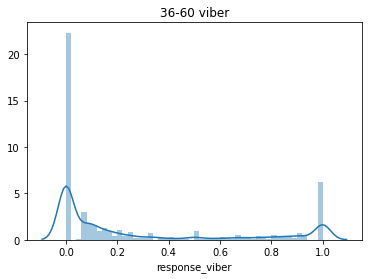

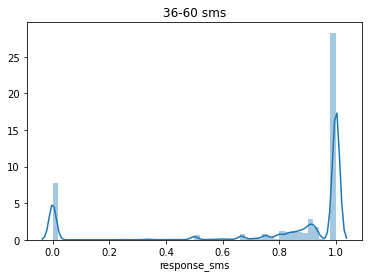

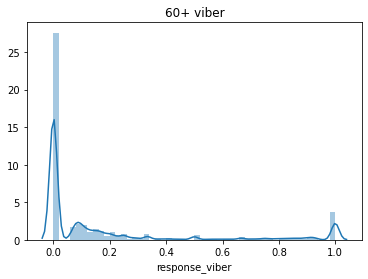

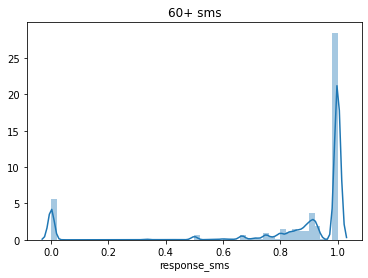

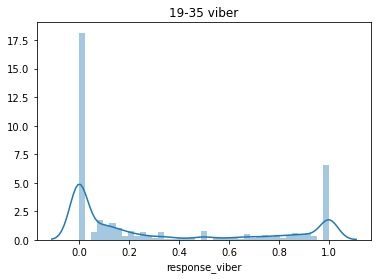

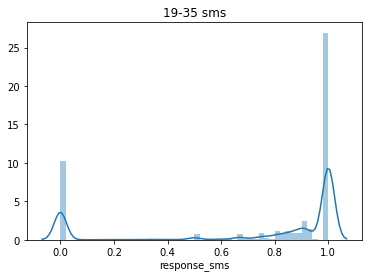

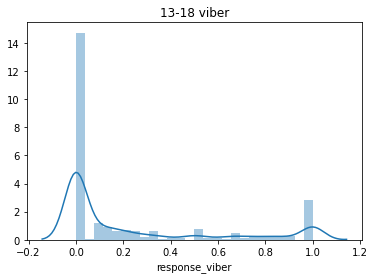

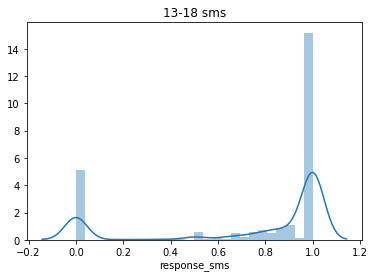

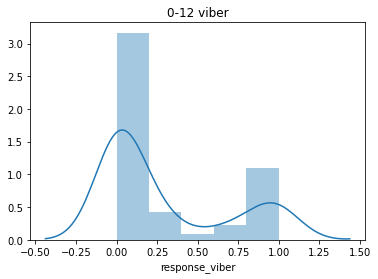

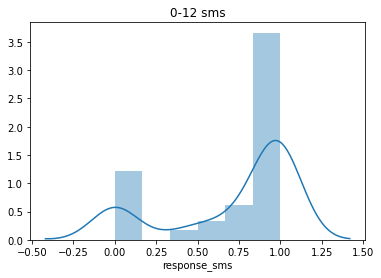

In [39]:
for g in pdf['age_group'].unique():
    temp = pdf[pdf['age_group']==g]
    sns.distplot(temp['response_viber'])
    plt.title(g + ' viber')
    plt.show()
    sns.distplot(temp['response_sms'])
    plt.title(g + ' sms')
    plt.show()

Among the audience up to 35 years old a fairly small response through SMS and Viber is observed. Perhaps these people use these communication channels for other needs.

**Solution of the problem:** to explore other markets for communication with the user, for example other messengers. In addition, in this way it is possible to reduce the number of sent SMS for this age group and significantly save the company’s budget.

## Aged people

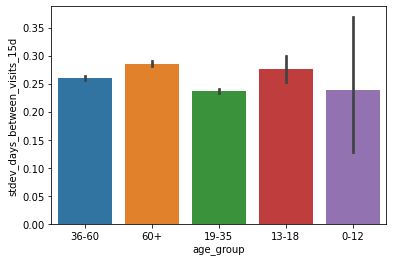

In [40]:
sns.barplot(x="age_group", y="stdev_days_between_visits_15d", data=pdf)

For the old people we can see one of the largest standard deviations between visits over the past 15 days. Likely it is due to physical capabilities.

**How to increase the number of visits of pensioners?** Make a delivery service or consultants who will accompany pensioners in stores.

## Conclusion

It's all. We hope you find this dataset analysis useful. If you have new ideas for insights write about them in the comments.